## This notebook is for the final ethograms in the heterogeneity paper
We would like to build an array of the enter and leave time for each ant.
We would also like to rank order.
Then color code it as to which nest is being entered as well as a background color corresponding to which role the ant is grouped in.
- New ethograms should get rid of LAI
- Keep color code
- Change orientation
- Change color palette (green/violet from viridis)

## Update (June 25, 2019)
- Get rid of title
- Reduce margins (plot fill figure)
- Remove frame around legend
- Add frame around plot (this is difficult. for now just do this in powerpoint)
- Increase symbol size in legen and plot
- Labels = "Good nest" "Mediocre nest" "Transport item" "Lead TR" "Follow TR"

## Update (June 28, 2019)
- Move legend below plot
- Get rid of tick at x=0
- Add vertical lines

## Update (Oct. 15, 2019)
- reduced width of  10-15%, increased height of 20%
- dashed lines colored in black
- if the above modifications let you increase the size of the symbols that would be great!

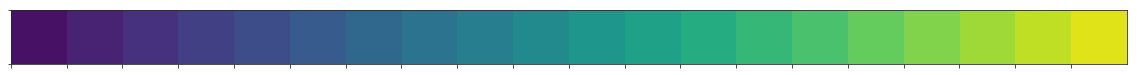

In [3]:
import seaborn as sns
# Load color palette
palette = sns.color_palette("viridis",20)
sns.palplot(palette)

Analyzing colony 6 treatment 1
Import Success!


Length of Trial [min]: 760.7666666666667
ERROR: Ant *w**0 Entered Nest without having left ( E -> BC ) at time 12:40:46
ERROR: Ant GB** Entered Nest without having left ( E -> E ) at time 12:23:37
ERROR: Ant GO** Entered Nest without having left ( TA -> E ) at time 09:37:56
ERROR: Ant GO** Entered Nest without having left ( E -> TU ) at time 10:16:59
ERROR: Ant GO** Entered Nest without having left ( TU -> TU ) at time 11:44:06
ERROR: Ant PO** Entered Nest without having left ( E -> E ) at time 11:43:59


/Users/jakehanson/.brew/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


ERROR: Ant WPWY Entered Nest without having left ( BC -> BC ) at time 12:40:38
ERROR: Ant YPP* Entered Nest without having left ( E -> E ) at time 10:25:45


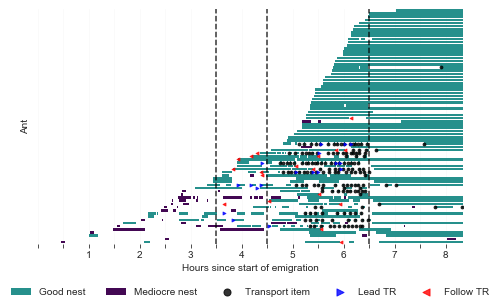

Analyzing colony 6 treatment 2
Import Success!


Length of Trial [min]: 317.93333333333334


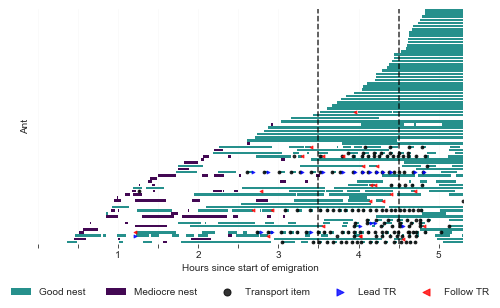

Analyzing colony 6 treatment 3
Import Success!


Length of Trial [min]: 778.9833333333333


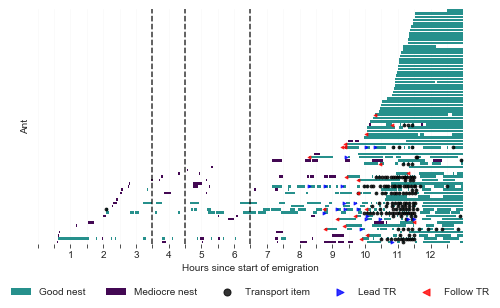

Analyzing colony 6 treatment 4
Import Success!


Length of Trial [min]: 266.68333333333334


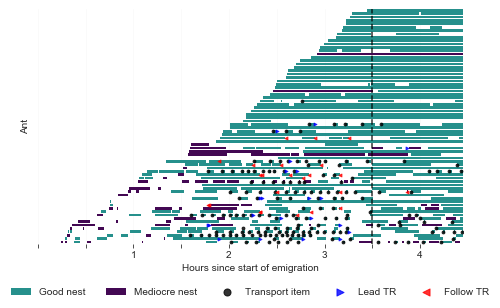

Analyzing colony 6 treatment 5
Import Success!


Length of Trial [min]: 366.7
ERROR: Ant **** Entered Nest without having left ( TA -> TA ) at time 02:30:26


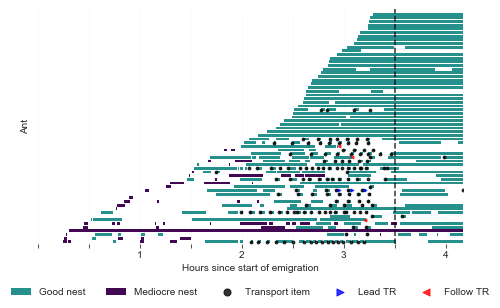

Done.


In [10]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
import matplotlib.patches as patches
%matplotlib inline

# Specify Treatment Info
col_id = '6'
# col_id = '208'
#col_id = '3004'
treatment_array = [1,2,3,4,5]
n_clusters = 2

# Store max time we would like to display (y_max) for plotting
MAX_TIME = {'6':{1:500,2:0,3:0,4:0,5:250},'208':{2:640,3:700,4:200,5:0},'3004':{1:0,2:600,3:250,4:0,5:0}}

# Store bad ants with coding errors (more on this in the cell below)
BAD_ANTS = {'6':{1:[],2:[],3:[],4:[],5:[]},'208':{2:[],3:['GBLO'],4:[],5:[]},'3004':{1:[],2:[],3:[],4:[],5:[]}}

## Build Ethograms
for treatment_id in treatment_array:
    
    print('Analyzing colony',col_id,'treatment',treatment_id)
    
#     # Get clustering data
#     path = '/Users/jakehanson/Desktop/New_Ethograms/Ethogram/Final_Clustering/classifications/kmeans_high_level/colony'+\
#     col_id+'Nclusters'+str(n_clusters)+'treatment'+str(treatment_id)+'.kmeans.hl.txt'
#     roles = pd.read_table(path,sep='\s')
#     n_ants = np.shape(roles)[0]
#     role_dict = {}
#     for i in range(0,n_ants):
#         role_dict[roles['colorId'][i]]=roles['role'][i]

    # Get emigration data and sort
    path = '../Improved_Treatments/Separate_Treatments/col' \
            +str(col_id)+'_treatment'+str(treatment_id)+'.csv'
    data = pd.DataFrame.from_csv(path)  
    data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.time
    if data.empty == False:
        print('Import Success!\n\n')
    else:
        print('ERROR!!! Data Frame is empty for colony',col_id,'treatment',treatment_id)    
    data = data.sort_values(['Ant','Time'],ascending=True)  # Sort by ant
    n_rows = np.shape(data)[0]
    data.index = np.arange(n_rows)  # Reindex accordingly
    

    # Get length of trial
    max_time = 0
    for i in range(n_rows):
        strip_time = time.strptime(str(data['Time'][i]),'%H:%M:%S')
        new_time = strip_time.tm_hour*60*60+strip_time.tm_min*60+strip_time.tm_sec
        new_time = new_time/60.

        if new_time > max_time:
            max_time = new_time
    print('Length of Trial [min]:',max_time)

    # Initialize
    ethogram = {}  # initialize empty dict to store the name of each ant and an array with important info
    old_ant = data['Ant'][0] # initialize which ant we are on
    counter = 1
    in_nest = False

    ethogram[old_ant] = [[0],[],[]]  # initialize first key with time of 0 and empty array for location
    ## First list is for the entry and exit times
    ## Second list is for which nest she is in
    ## Third list is for times of completed transports
    
    # Create dicts to store time they begin to lead or follow a TR 
    lead_TR = {}
    follow_TR = {}
    lead_TR[old_ant] = []
    follow_TR[old_ant] = []

    
    # Build ethograms
    for i in range(0,n_rows):
        new_ant = data['Ant'][i]
        if new_ant != old_ant and new_ant != 'OldUncoded':
            # Check if the previous ant never left
            if in_nest == True:
                ethogram[old_ant][0].append(max_time)            
            # Reset and initialize
            in_nest = False  # All ants start outside of nest
            counter = counter + 1
            old_ant = new_ant
            ethogram[new_ant] = [[0],[],[]]
            lead_TR[new_ant] = []
            follow_TR[new_ant] = []
            
        if data['Behavior'][i] == 'LB':
            # Get time
            strip_time = time.strptime(str(data['Time'][i]),'%H:%M:%S')
            TR_time = strip_time.tm_hour*60*60+strip_time.tm_min*60+strip_time.tm_sec
            TR_time = TR_time/60.  # convert to minutes
            lead_TR[new_ant].append(TR_time)
 
        if data['Behavior'][i] == 'FB':
            # Get time
            strip_time = time.strptime(str(data['Time'][i]),'%H:%M:%S')
            TR_time = strip_time.tm_hour*60*60+strip_time.tm_min*60+strip_time.tm_sec
            TR_time = TR_time/60.  # convert to minutes
            follow_TR[new_ant].append(TR_time)
            

        # Enter Nest (E), Carried into Nest (BC), Transport In (TB,TU,TA)
        if data['Behavior'][i] == 'E' or data['Behavior'][i] == 'BC' or \
        data['Behavior'][i] == 'TB' or data['Behavior'][i] == 'TU' or data['Behavior'][i] == 'TA':
            if in_nest == True:
                print('ERROR: Ant',new_ant,'Entered Nest without having left (',data['Behavior'][i-1],'->',data['Behavior'][i],') at time',data['Time'][i])
            in_nest = True
                
            nest_site = data['Location/Origin'][i]

            # Get entry time
            strip_time = time.strptime(str(data['Time'][i]),'%H:%M:%S')
            entry_time = strip_time.tm_hour*60*60+strip_time.tm_min*60+strip_time.tm_sec
            entry_time = entry_time/60.  # convert to minutes
            ethogram[new_ant][0].append(entry_time)
            ethogram[new_ant][1].append(nest_site)

            # Special line for transports
            if data['Behavior'][i] == 'TB' or data['Behavior'][i] == 'TU' or data['Behavior'][i] == 'TA':
                ethogram[new_ant][2].append(entry_time)
            

        # Did they leave on their own accord
        if data['Behavior'][i] == 'L' or data['Behavior'][i] == 'TAO' or \
        data['Behavior'][i] == 'TBO' or data['Behavior'][i] == 'BCO': 
            if in_nest == False:
                print('ERROR: Ant',new_ant,'Left Nest without having entered (',data['Behavior'][i-1],'->',data['Behavior'][i],') at time',data['Time'][i])
                in_nest = False
            else:
                in_nest = False

            # Get exit time
            strip_time = time.strptime(str(data['Time'][i]),'%H:%M:%S')
            exit_time = strip_time.tm_hour*60*60+strip_time.tm_min*60+strip_time.tm_sec
            exit_time = exit_time/60.
            delta_time = exit_time - entry_time
            if delta_time <= 0:
                print('ERROR: Non-positive time spent in nest!')
                # Raise a flag that makes the data not included
            else:
                ethogram[new_ant][0].append(exit_time)
                ethogram[new_ant][1].append(nest_site)

    # If the last ant ended inside the nest, make sure we append the final time
    if in_nest == True:
        ethogram[new_ant][0].append(max_time)   
        
    # Remove bad ants from data
    for bad_ant in BAD_ANTS[col_id][treatment_id]:
        print("Ant",bad_ant,"has been removed")
        ethogram.pop(bad_ant,None)
        lead_TR.pop(bad_ant,None)
        follow_TR.pop(bad_ant,None)
#         role_dict.pop(bad_ant,None)  
    
    
    ## BEGIN PLOT
    
    # Create a dict with the rank order for each ant
    temp_list = []
    for key in ethogram.keys():
        temp_list.append([key,np.size(ethogram[key][0]),ethogram[key][0][1]])  # store name, number events, and time of first entry
            
    # Sort this dict by either frequency then entry or vis versa
    index_2 = 'Freq'
    index_1 = 'Entry_Time'
    if index_1 == 'Entry_Time' and index_2 == 'Freq':
        ranked_list = sorted(temp_list,key=itemgetter(1),reverse=True)
        ranked_list = sorted(ranked_list,key=itemgetter(2),reverse=False)
        rank_dict = {}
        counter = 0
        for each in ranked_list:
            rank_dict[each[0]] = counter
            counter = counter + 1
    elif index_2 == 'Entry_Time' and index_1 == 'Freq':
        ranked_list = sorted(temp_list,key=itemgetter(2),reverse=False)
        ranked_list = sorted(ranked_list,key=itemgetter(1),reverse=True)
        rank_dict = {}
        counter = 0
        for each in ranked_list:
            rank_dict[each[0]] = counter
            counter = counter + 1

    ## Make Bar Plot
    sns.set_style("ticks")
#     fig = plt.figure(figsize=(8,4.5))
    fig = plt.figure(figsize=(6.8,5.4))
    ax = plt.subplot(111)

    # Create lists to store which ants belong to which clustering result
    counter = 0
    x_locations = []  # list to store the order of locations
#     active_ants = []  # cluster result 1 
#     passive_ants = []  # cluster result 2


    ## Make bars
    for i in ethogram.keys():
        
        # Get location
        location = rank_dict[i]
        x_locations.append(location)
        
        # store roles
#         if role_dict[i] == 'active':
#             active_ants.append(location)
#         elif role_dict[i] == 'passive':
#             passive_ants.append(location)
        for j in range(0,np.size(ethogram[i][0])-1):
            # Height of bar
            height = ethogram[i][0][j+1] - ethogram[i][0][j]  # height of bar
            if (j+1)%2 == 0:  # every other j we are at a new place
                nest_site = ethogram[i][1][j-1]                
                if nest_site == 'good':
                    good_bar = ax.barh(location,height,color='#26908C',alpha=1.0,left=ethogram[i][0][j],zorder=1,linewidth=0)
                else:
                    bad_bar = ax.barh(location,height,color='#430853',alpha=1.0,left=ethogram[i][0][j],zorder=1,linewidth=0)
            
            # plot clear bar if we are outside nest
            else:
                alphaz = 0.0
                clear_bar = ax.barh(location,height,color='white',alpha=alphaz,left=ethogram[i][0][j],zorder=1,linewidth=0)
        counter = counter + 1
        
#     # Plot roles as background bars
#     if active_ants:
#         active_bar = ax.barh(active_ants,[max_time]*np.size(active_ants),color=palette[-2],alpha=0.2,left=0.,zorder=-1)
#     if passive_ants:
#         passive_bar = ax.barh(passive_ants,[max_time]*np.size(passive_ants),color=palette[0],alpha=0.2,left=0.,zorder=-1)

    # Plot completed transports
    names_of_transporters = []
    times_of_transports = []
    for each in ethogram.keys():
        # if they had a transport record it
        if len(ethogram[each][2]) > 0:
            for i in range(len(ethogram[each][2])):
                names_of_transporters.append(rank_dict[each]+0.5)
                times_of_transports.append(ethogram[each][2][i])
    scatter_transport = ax.scatter(times_of_transports,names_of_transporters-np.asarray(0.5),color='black',marker='o',s=8,zorder=10,alpha=0.8,label='First Transport')
    
    # Plot TR (lead)
    names_of_transporters = []
    times_of_TR = []
    for each in lead_TR.keys():
        # if they lead a TR record it
        if len(lead_TR[each]) > 0:
            for i in range(len(lead_TR[each])):
                names_of_transporters.append(rank_dict[each]+0.5)
                times_of_TR.append(lead_TR[each][i])
    scatter_lead = ax.scatter(times_of_TR,names_of_transporters-np.asarray(0.5),color='blue',marker=">",s = 8, zorder=10,alpha=0.8,label='Lead TR')

    # Plot first TR (follow)
    names_of_transporters = []
    times_of_TR = []
    for each in follow_TR.keys():
        # if they followed a TR record it
        if len(follow_TR[each]) > 0:
            for i in range(len(follow_TR[each])):
                names_of_transporters.append(rank_dict[each]+0.5)
                times_of_TR.append(follow_TR[each][i])
    scatter_follow = ax.scatter(times_of_TR,names_of_transporters-np.asarray(0.5),color='red',marker="<",s = 8, zorder=10,alpha=0.8,label='Follow TR')
            
    # Clean up Plot (note x/y were switched at some point)
    plt.xlabel('Hours since start of emigration',size=10)
    plt.ylabel('Ant',size=10)
#     plt.ylim((-0.5,np.size(ethogram.keys())+2))

    # Configure x-axis
    if MAX_TIME[col_id][treatment_id] != 0:
        max_time = MAX_TIME[col_id][treatment_id] # get max time
    plt.xlim(0,max_time)
    n_hours = max_time/60.
    hour_ticks = np.arange(0.,n_hours,0.5)  # x labels
    hour_strings = []
    for each in hour_ticks:
        hour_strings.append(str(int(each))) # convert to strings
    plt.xticks(hour_ticks*60,hour_strings)
    plt.setp(ax.get_xticklabels()[1::2], visible=False)  # Drop every other label
    plt.setp(ax.get_xticklabels()[0], visible=False)  # Drop first label (0)
    ax.xaxis.grid(True,alpha=0.1) # Turn on an x-grid

    # Configure y-axis
    plt.yticks(x_locations+np.asarray(0.25), [])
#     plt.yticks(x_locations+np.asarray(0.25), ethogram.keys(),rotation=0,size=4)
    plt.ylim((-0.5,len(x_locations)-0.5))
    ax.yaxis.set_tick_params(length=0.)  # turn off ticks without turning off labels
    
    # Legend
    box = ax.get_position()
    # Shrink current axis's height by 20% on the bottom
    ax.set_position([box.x0, box.y0+box.height * 0.2, box.width*1.12, box.height*0.8])

    ## add verticle lines
    v_lines = [3.5,4.5,6.5]
    for line in v_lines:
        if line < n_hours:
            plt.axvline(line*60,linestyle='dashed',color='black',alpha=0.8)


#     plt.title('Colony '+str(col_id)+' Treatment '+ \
#               str(treatment_id) ,size=10,fontweight='bold')
    lgd = ax.legend((good_bar,bad_bar,scatter_transport,scatter_lead,scatter_follow),('Good nest','Mediocre nest','Transport item', 'Lead TR', 'Follow TR'),
              loc='upper center', markerscale=2.5, frameon=False, bbox_to_anchor=(0.5, -0.15),ncol=5) 

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    
    ## Save
    plt.savefig('./Results/col'+str(col_id)+'_t'+str(treatment_id)+'.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

print("Done.")

## Notes about coding errors:
- Col 6 t1: Coding errors only showed up above the max time, so are not visible in these ethograms
- Col 6 t5: **** had an L (2:21:18) followed by an L (2:25:06). Former was removed from data.
- Col 6 t5: **** had a TA->TA but it occured after the max time, so it was ignored.
- Col 208 t2: GOYL had L->BCO but it occured after the max time, so it was ignored.
- Col 208 t3: GGYO had an FB followed by L. I assumed FB was E
- Col 208 t3: GBLO had L to BCO that could not be resolved. Ant was removed from data.
- Col 3004 t1: **** (very active ant) had TB without an L (11:40:16). The average time for an L after a TB was calcuted using the prior and following TB/L pairs and inserted at the resulting time (11:41:06).
- Col 3004 t2: **** (very active ant) had E (4:33:20) followed by E (5:04:18). Former was removed from data.
- Col 3004 t3: **** (very active ant) had L (56:01) followed by L (1:07:32). Latter was removed from data.
- Col 3004 t3: **** (very active ant) had E (2:41:14) followed by E (2:53:43). Former was removed from data.
- Col 3004 t3: **** (very active ant) had TB (3:02:05) followed by FB (3:03:36). L was added 13s after FB, to complete the TB->FB->L motif that immediately proceeds this behavior.

#### It's surprising how often they lead a TR after transporting given that transporting is a "switch" that gets flipped on

In [23]:
help(plt.hline())

AttributeError: module 'matplotlib.pyplot' has no attribute 'hline'